In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import cv2
# use pytorch (better support for 5070 ti on windows than tensorflow)

In [10]:
# following function will downscale photos
def bicubic_2x_downscale(hr_img_arr):
    height, width = hr_img_arr.shape[:2]
    
    new_width = width // 2
    new_height = height // 2
    
    lr_img_arr = cv2.resize(
        hr_img_arr, 
        (new_width, new_height), 
        interpolation=cv2.INTER_CUBIC
    )
    
    return lr_img_arr

In [11]:
hr_dir = os.path.join(".", "div2k_images", "hr")
train_paths = glob.glob(os.path.join(hr_dir, "train", "*.png"))
val_paths = glob.glob(os.path.join(hr_dir, "val", "*.png"))

train_y = []
train_x = []
for path in train_paths:
    img = Image.open(path)
    img_arr = np.array(img)
    train_x.append(bicubic_2x_downscale(img_arr))
    train_y.append(img_arr)

val_y = []
val_x = []
for path in val_paths:
    img = Image.open(path)
    img_arr = np.array(img)
    val_x.append(bicubic_2x_downscale(img_arr))
    val_y.append(img_arr)

In [12]:
print(train_x[0].shape)
print(train_y[0].shape)

(702, 1020, 3)
(1404, 2040, 3)


/storage/hf-datasets-cache/all/datasets/49462443184839-config-parquet-and-info-eugenesiow-Div2k-fb07ea00/downloads/extracted/d378c8c72bb30a2b7e2ce6f9fa7eb0f2bdece621e9c667e5e474d0698920cbec/DIV2K_train_LR_bicubic/X2/0001x2.png


FileNotFoundError: [WinError 3] The system cannot find the path specified

(1404, 2040, 3)


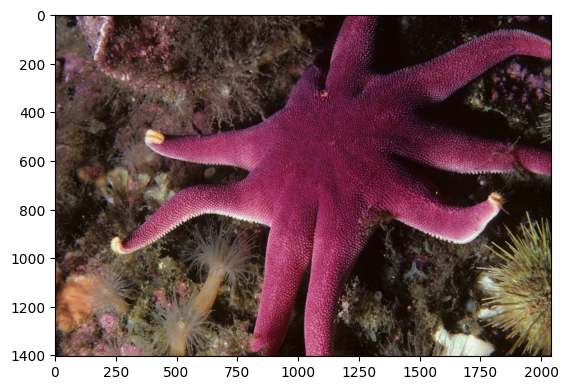

In [ ]:
image_array = train_y[0]
print(image_array.shape)

imgplot = plt.imshow(image_array)

In [5]:
# Because the dataset is not of a uniform size, training will be pain in the ass, 
# splitting into 32 x 32 blocks will take long. Not worth spending time on this. 
# pick a different dataset that's uniform. 
for i in range(30):
    print(ds['train'][i])

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2040x1404 at 0x19089B53290>, 'label': 2}
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2040x1848 at 0x19089B52F90>, 'label': 2}
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2040x1344 at 0x19089B531D0>, 'label': 2}
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1608x2040 at 0x19089B53290>, 'label': 2}
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2040x1356 at 0x19089B52F90>, 'label': 2}
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2040x1356 at 0x19089B531A0>, 'label': 2}
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2040x1524 at 0x19089B50890>, 'label': 2}
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2040x1644 at 0x19089B52F90>, 'label': 2}
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2040x1356 at 0x19089B52F90>, 'label': 2}
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2

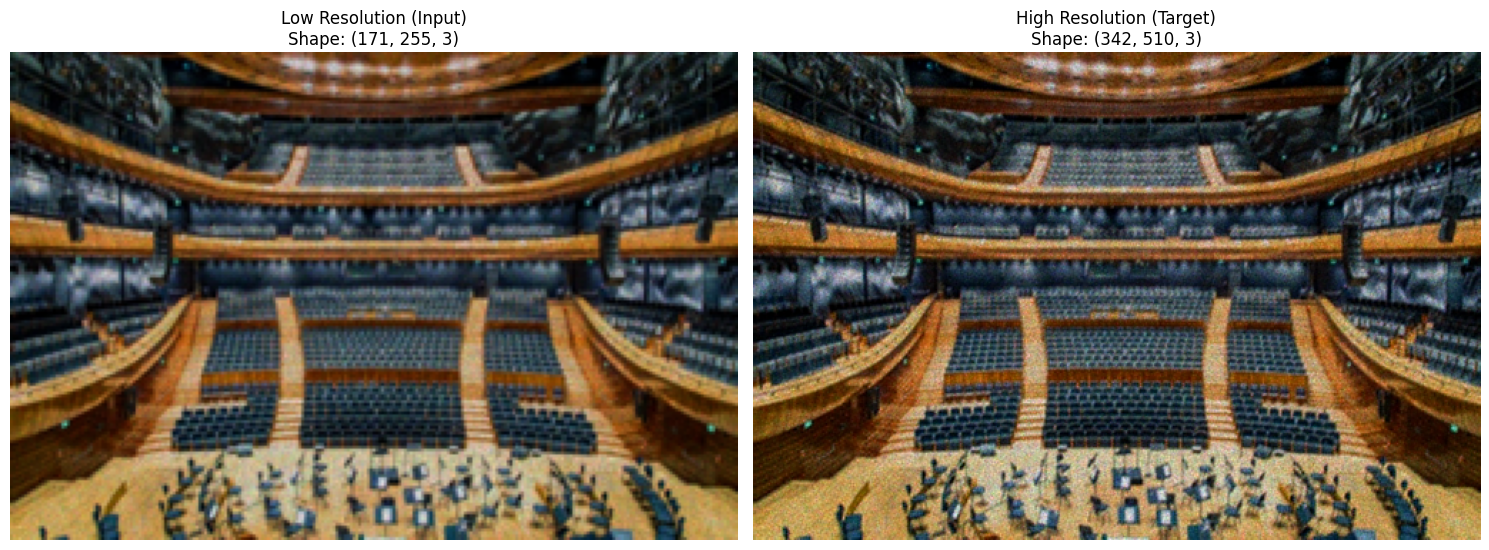

LR Image min/max: 0.00 / 0.93
HR Image min/max: 0.00 / 1.00


2025-12-04 18:27:35.956175: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Convert training images into 32 x 32 numpy blocks; 
# leave test images as is (inference should not break photo up into pieces);


In [10]:
print(type(train_dataset))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [6]:
# Create super-resolution model
def create_model():
    model = keras.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2DTranspose(
            filters=64,
            kernel_size=11,
            strides=4,
            padding='same',
            activation='sigmoid'
        ),
        layers.Conv2DTranspose(
            filters=32,
            kernel_size=9,
            strides=2,
            padding='same',
            activation='sigmoid'
        ),
        layers.Conv2DTranspose(
            filters = 16,
            kernel_size=9,
            strides=1,
            padding='same',
            activation='sigmoid'
        ),
        layers.Conv2DTranspose(
            filters = 16,
            kernel_size=9,
            strides=1,
            padding='same',
            activation='sigmoid'
        ),
        layers.Conv2DTranspose(
            filters = 3,
            kernel_size=5,
            strides=1,
            padding='same',
            activation='sigmoid'
        ),
        layers.AveragePooling2D(pool_size=(2,2)),
        layers.AveragePooling2D(pool_size=(2,2))
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = create_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_6              │ (None, 128, 128, 64)   │        23,296 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 256, 256, 32)   │       165,920 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 256, 256, 16)   │        41,488 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 256, 256, 16)   │        20,752 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 256, 256, 3)    │         1,203 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 128, 128, 3)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 64, 64, 3)      │             0 │
│ (AveragePooling2D)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,659 (986.95 KB)

 Trainable params: 252,659 (986.95 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Calculate the number of batches (steps)
# Since batch size is 1, steps = number of images
num_train_steps = len(train_val_split['train'])
num_val_steps = len(train_val_split['test'])

print(f"Training steps per epoch: {num_train_steps}")
print(f"Validation steps per epoch: {num_val_steps}")

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    steps_per_epoch=num_train_steps,  
    validation_steps=num_val_steps   
)

NameError: name 'train_val_split' is not defined

In [ ]:
# Calculate the number of test batches
# Since batch size is 1, steps = number of images
num_test_steps = len(ds['test'])

print(f"Test steps: {num_test_steps}")
print("Evaluating model on the test set...")
loss, mae = model.evaluate(
    test_dataset,
    steps=num_test_steps
)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

Test steps: 320
Evaluating model on the test set...
 70/320 ━━━━━━━━━━━━━━━━━━━━ 56s 227ms/step - loss: 0.0170 - mae: 0.1106

KeyboardInterrupt: 